### Models

In [25]:
from pydantic import BaseModel, EmailStr
from datetime import date
from uuid import UUID, uuid4

In [28]:
class Employee(BaseModel):
    employee_id: UUID = uuid4()
    first_name: str
    last_name: str
    email: EmailStr
    date_of_birth: date
    salary: float
    department: str

In this example, user is an instance of User. Initialization of the object will perform all parsing and validation. If no ValidationError is raised, you know the resulting model instance is valid.

In [30]:
employee = Employee(
    first_name="Chris",
    last_name="DeTuma",
    email="cdetuma@fakeprovider.com",
    date_of_birth="1998-09-23",
    salary=50000,
    department="engineering"
)
employee

Employee(employee_id=UUID('64f0fc09-8ab6-4124-9a8f-5f775f670f1b'), first_name='Chris', last_name='DeTuma', email='cdetuma@fakeprovider.com', date_of_birth=datetime.date(1998, 9, 23), salary=50000.0, department='engineering')

In [36]:
employee = Employee(
    employee_id="43",
    first_name="Chris",
    last_name="DeTuma",
    email="cdetumafakeprovider.invalid",
    date_of_birth="1998-09-233",
    salary=50000,
    department="engineering"
)
employee

ValidationError: 3 validation errors for Employee
employee_id
  Input should be a valid UUID, invalid length: expected length 32 for simple format, found 2 [type=uuid_parsing, input_value='43', input_type=str]
    For further information visit https://errors.pydantic.dev/2.5/v/uuid_parsing
email
  value is not a valid email address: The email address is not valid. It must have exactly one @-sign. [type=value_error, input_value='cdetumafakeprovider.invalid', input_type=str]
date_of_birth
  Input should be a valid date or datetime, invalid datetime separator, expected `T`, `t`, `_` or space [type=date_from_datetime_parsing, input_value='1998-09-233', input_type=str]
    For further information visit https://errors.pydantic.dev/2.5/v/date_from_datetime_parsing

In [37]:
employee.model_dump()

{'employee_id': UUID('af47b66b-72f8-42e2-a40f-4139fcdbfa3d'),
 'first_name': 'Chris',
 'last_name': 'DeTuma',
 'email': 'cdetuma@fakeprovider.com',
 'date_of_birth': datetime.date(1998, 9, 23),
 'salary': 50000.0,
 'department': 'engineering'}

In [38]:
employee.model_dump_json()

'{"employee_id":"af47b66b-72f8-42e2-a40f-4139fcdbfa3d","first_name":"Chris","last_name":"DeTuma","email":"cdetuma@fakeprovider.com","date_of_birth":"1998-09-23","salary":50000.0,"department":"engineering"}'

In [39]:
employee.model_validate_json('{"id":1,"name":"bitch"}')

ValidationError: 6 validation errors for Employee
first_name
  Field required [type=missing, input_value={'id': 1, 'name': 'bitch'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.5/v/missing
last_name
  Field required [type=missing, input_value={'id': 1, 'name': 'bitch'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.5/v/missing
email
  Field required [type=missing, input_value={'id': 1, 'name': 'bitch'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.5/v/missing
date_of_birth
  Field required [type=missing, input_value={'id': 1, 'name': 'bitch'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.5/v/missing
salary
  Field required [type=missing, input_value={'id': 1, 'name': 'bitch'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.5/v/missing
department
  Field required [type=missing, input_value={'id': 1, 'name': 'bitch'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.5/v/missing

The Field function is used to customize and add metadata to fields of models.

In [41]:
from pydantic import Field

class Employee(BaseModel):
    employee_id: UUID = Field(default_factory=lambda: uuid4(), frozen=True)
    first_name: str = Field(min_length=1, frozen=True)
    last_name: str = Field(min_length=1, frozen=True)
    email: EmailStr
    date_of_birth: date = Field(alias="birth_date", repr=False, frozen=True)
    start_date: date
    salary: float = Field(gt=0, repr=False)
    seniority: str
    department: str

validators

In [55]:
from pydantic import field_validator, model_validator
from typing import Any

class Employee(BaseModel):
    employee_id: UUID = Field(default_factory=lambda: uuid4(), frozen=True)
    first_name: str = Field(min_length=1, frozen=True)
    last_name: str = Field(min_length=1, frozen=True)
    email: EmailStr
    date_of_birth: date = Field(alias="birth_date", repr=False, frozen=True)
    start_date: date
    salary: float = Field(gt=0, repr=False)
    seniority: str
    department: str
    
    @model_validator(mode="before")
    @classmethod
    def check_ssn_omitted(cls, data: Any) -> Any:
        if isinstance(data, dict):
            assert ("ssn" not in data), "ssn should not be included"
        return data
    
    @field_validator("department")
    @classmethod
    def check_valid_department(cls, v: str) -> str:
        
        if v.lower() not in ["marketing", "hr", "engineering"]:
            raise ValueError("Invalid department")
    
        return v

In [58]:
employee = Employee(
    first_name="Chris",
    last_name="Davis",
    email="cdavis@company.net",
    birth_date="1987-09-01",
    start_date="2022-02-02",
    salary=250000,
    seniority="ic",
    department="Engineering"
)
employee

Employee(employee_id=UUID('bd51ad4d-5943-46ba-bb31-70bcd71207a4'), first_name='Chris', last_name='Davis', email='cdavis@company.net', start_date=datetime.date(2022, 2, 2), seniority='ic', department='Engineering')

In [65]:
from pydantic import PositiveFloat, validate_call

In [70]:
@validate_call
def send_billing_email(client_name:str,
                       client_email:EmailStr,
                       items_purchased:list[str],
                       amount_owed:PositiveFloat) -> None:
    
    email_str = f""" 
    Dear {client_name},
    
    Thank you for choosing xyz inc! You
    owe ${amount_owed:,.2f} for the follwoing items:
    
    {items_purchased}
    """
    
    print(f"Sending to {client_email}...")
    print(email_str)
    print("Sent!")
    

In [71]:
send_billing_email(
    client_name="Chris Davis",
    client_email="cdavis@company.com",
    items_purchased=["biscuit", "pie", "cake"],
    amount_owed=50.47
)

Sending to cdavis@company.com...
 
    Dear Chris Davis,
    
    Thank you for choosing xyz inc! You
    owe $50.47 for the follwoing items:
    
    ['biscuit', 'pie', 'cake']
    
Sent!


In [72]:
pip install pydantic-settings

  Obtaining dependency information for pydantic-settings from https://files.pythonhosted.org/packages/5d/c9/8042368e9a1e6e229b5ec5d88449441a3ee8f8afe09988faeb190af30248/pydantic_settings-2.1.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [167]:
from pydantic_settings import BaseSettings, SettingsConfigDict
from pydantic import HttpUrl
import os

In [176]:
class AppConfig(BaseSettings):
    database_user:str
    database_password:str
    api_key:str
    service_host:HttpUrl
    

In [177]:
config = AppConfig()

In [178]:
config.service_host

Url('http://localhost:8501/')

In [191]:
class ReleaseConfig(BaseModel):
    release_env:str 
    regions:list[str]
    
    @field_validator("release_env")
    @classmethod
    def check_valid_envs(cls, v: str) -> str:
        
        if v not in ["dev", "stage", "prod"]:
            
            raise ValueError(f"{v} is not valid")
    
        return v
    
    @field_validator("regions")
    @classmethod
    def check_valid_regions(cls, v: str) -> str:
        
        for region in v:
            
            if region not in ["us-east-1", "us-east-2", "us-west-1", "us-west-2"]:
                
                raise ValueError(f"{region} is not valid")
    
        return v

In [192]:
class AppConfig(BaseSettings):
    database_user: str
    database_password: str
    api_key: str
    service_host: HttpUrl
    release_config: ReleaseConfig

In [197]:
os.environ["DATABASE_USER"] = "username"
os.environ["DATABASE_PASSWORD"] = "fakepassword"
os.environ["API_KEY"] = "1234jklfgre4"
os.environ["SERVICE_HOST"] = "http://localhost:8501"
os.environ["RELEASE_CONFIG"] = '{"release_env": "prod", "regions": ["us-east-1", "us-west-2"]}'

In [198]:
config = AppConfig()

In [132]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

In [125]:
def truncated_normal(mean, std_dev, lower_bound, upper_bound, size=1):
    # Generate samples from a normal distribution
    samples = np.random.normal(mean, std_dev, size)

    # Truncate the values to the specified range
    truncated_samples = np.clip(samples, lower_bound, upper_bound)

    return truncated_samples

0.612768896889689


(array([0.17188316, 0.51564948, 1.54694843, 2.06259791, 2.23448107,
        2.57824738, 2.40636423, 2.40636423, 1.89071475, 1.37506527]),
 array([0.22343879, 0.28161784, 0.3397969 , 0.39797596, 0.45615501,
        0.51433407, 0.57251313, 0.63069218, 0.68887124, 0.74705029,
        0.80522935]),
 <BarContainer object of 10 artists>)

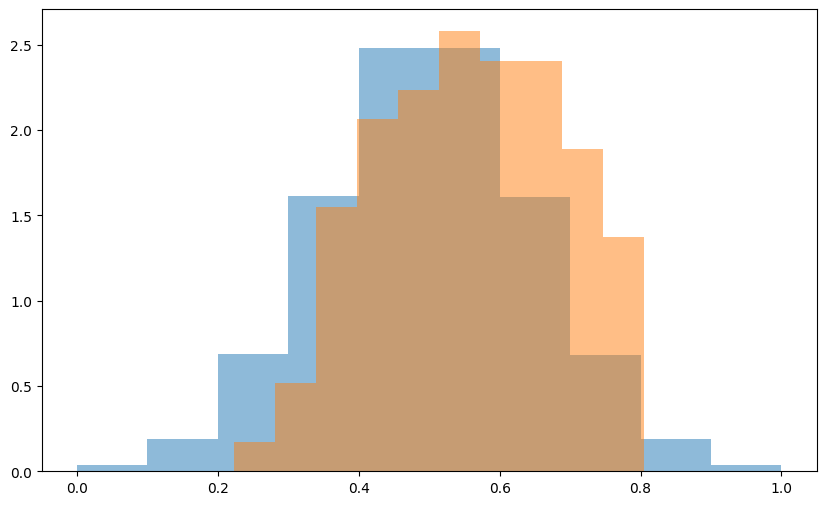

In [131]:
n = 1_000_000
num_positives = 100
num_negatives = n - num_positives

preds_0 = truncated_normal(0.50, 0.15, 0, 1, size=num_negatives)
preds_1 = truncated_normal(0.55, 0.15, 0, 1, size=num_positives)

y_test = np.concatenate((np.ones(num_positives), np.zeros(num_negatives)))
preds = np.concatenate((preds_1, preds_0))


fig, ax = plt.subplots(figsize=(10, 6))

print(roc_auc_score(y_test, preds))
ax.hist(preds_0, density=True, alpha=0.5)
ax.hist(preds_1, density=True, alpha=0.5)

In [134]:
from tqdm import tqdm

In [147]:
n = 1_000_000
num_positives = 1000
num_negatives = n - num_positives

y_test = np.concatenate((np.ones(num_positives), np.zeros(num_negatives)))

mu_deltas = np.arange(0.001, 0.25, 0.001)

roc_aucs = []
pr_aucs = []


for mu_delta in tqdm(mu_deltas):
    
    preds_0 = truncated_normal(0.50 - mu_delta, 0.15, 0, 1, size=num_negatives)
    preds_1 = truncated_normal(0.50 + mu_delta, 0.15, 0, 1, size=num_positives)
    preds = np.concatenate((preds_1, preds_0))
    
    roc_aucs.append(roc_auc_score(y_test, preds))
    pr_aucs.append(average_precision_score(y_test, preds))
    
roc_aucs
    

100%|██████████| 249/249 [02:07<00:00,  1.96it/s]


[0.5032207927927929,
 0.5097882582582582,
 0.5164666746746747,
 0.5196503173173173,
 0.5142645740740741,
 0.5222197867867868,
 0.5280984744744746,
 0.5220199269269269,
 0.5295338778778779,
 0.5424813953953953,
 0.5539213738738739,
 0.5350114324324324,
 0.5461897467467468,
 0.5460341841841841,
 0.5585696351351351,
 0.5468557477477477,
 0.5653595745745746,
 0.5505714389389389,
 0.5823374659659659,
 0.5865553033033033,
 0.584468454954955,
 0.5895396306306306,
 0.5844123863863864,
 0.607969430930931,
 0.5919782732732733,
 0.5727158928928928,
 0.5971778298298298,
 0.6140065325325326,
 0.6075951456456457,
 0.612212993993994,
 0.6158526701701701,
 0.6099256276276276,
 0.6213094734734735,
 0.6379862602602602,
 0.6417161491491491,
 0.6371974434434434,
 0.6439415755755756,
 0.6372875225225225,
 0.632772098098098,
 0.6493369514514515,
 0.6495667957957958,
 0.6685087967967968,
 0.6647619164164165,
 0.66528,
 0.665237492992993,
 0.6826481461461462,
 0.6701004514514515,
 0.6572438588588589,
 0.67996

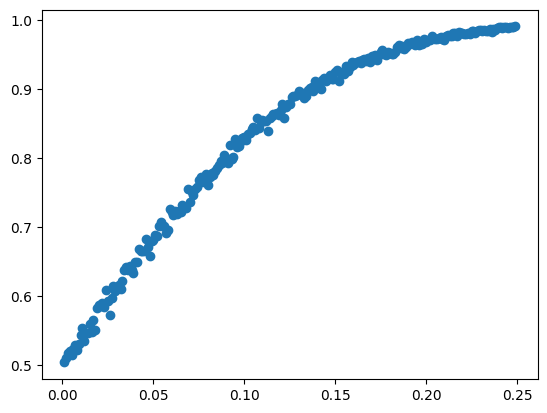

In [148]:
plt.scatter(mu_deltas , roc_aucs)

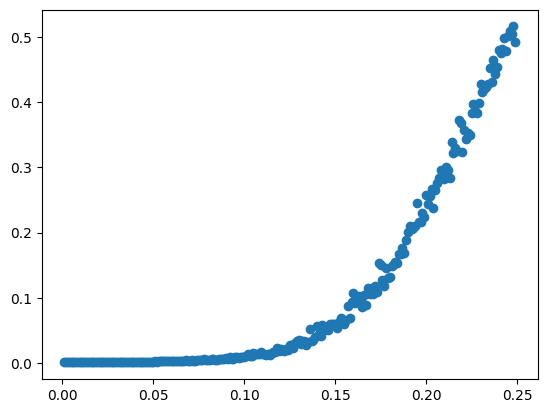

In [149]:
plt.scatter(mu_deltas , pr_aucs)

0.6705377337733773


(array([1.34997605, 1.49997339, 1.94996541, 4.04992816, 2.24996009,
        1.49997339, 1.34997605, 0.29999468, 0.59998936, 0.14999734]),
 array([0.29073541, 0.35740326, 0.4240711 , 0.49073895, 0.5574068 ,
        0.62407465, 0.6907425 , 0.75741035, 0.8240782 , 0.89074605,
        0.9574139 ]),
 <BarContainer object of 10 artists>)

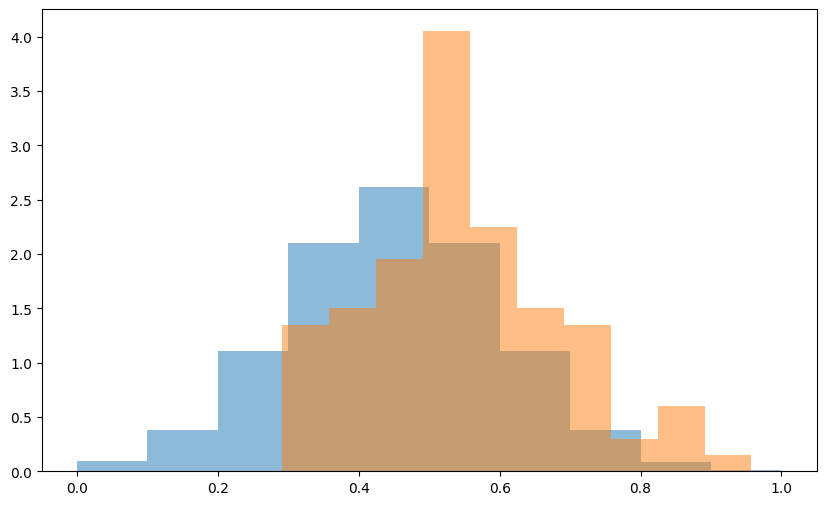

In [150]:
n = 1_000_000
num_positives = 100
num_negatives = n - num_positives

preds_0 = truncated_normal(0.45, 0.15, 0, 1, size=num_negatives)
preds_1 = truncated_normal(0.55, 0.15, 0, 1, size=num_positives)

y_test = np.concatenate((np.ones(num_positives), np.zeros(num_negatives)))
preds = np.concatenate((preds_1, preds_0))


fig, ax = plt.subplots(figsize=(10, 6))

print(roc_auc_score(y_test, preds))
ax.hist(preds_0, density=True, alpha=0.5)
ax.hist(preds_1, density=True, alpha=0.5)